# Retail Demand Forecasting – Data Analysis Notebook

## Step 1 – Load Raw Dataset

In this step, we load the raw Kaggle dataset (`train.csv`) to take a first look at the data.  
We’ll check the column names, data types, and see a few sample rows.

In [2]:
import pandas as pd

df = pd.read_csv('../data/raw/train.csv')
df.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


### Check Dataset Size

Here we check how many rows and columns are in the dataset.

In [3]:
df.shape

(3000888, 6)

## Step 2 – Data Cleaning

We’ll prepare the dataset by converting the `date` column to datetime,  
sorting the data properly, and handling any missing values.  
This ensures the data is consistent and ready for analysis.

In [4]:
df['date'] = pd.to_datetime(df['date'])

df = df.sort_values(['store_nbr', 'family', 'date']).reset_index(drop=True)

df['sales'] = df['sales'].fillna(0).astype(float)
df['onpromotion'] = df['onpromotion'].fillna(0).astype(int)

df.to_csv('../data/processed/train_clean.csv', index=False)

df.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1782,2013-01-02,1,AUTOMOTIVE,2.0,0
2,3564,2013-01-03,1,AUTOMOTIVE,3.0,0
3,5346,2013-01-04,1,AUTOMOTIVE,3.0,0
4,7128,2013-01-05,1,AUTOMOTIVE,5.0,0


### Save Cleaned Data

We’ll save the cleaned dataset into the `data/processed` folder for later use.

## Step 3 – Exploratory Data Analysis (EDA)

Now that the dataset is cleaned, we can explore it using summary statistics  
and visualisations to understand sales behaviour, patterns, and seasonality.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the cleaned dataset
df = pd.read_csv('../data/processed/train_clean.csv')

df.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1782,2013-01-02,1,AUTOMOTIVE,2.0,0
2,3564,2013-01-03,1,AUTOMOTIVE,3.0,0
3,5346,2013-01-04,1,AUTOMOTIVE,3.0,0
4,7128,2013-01-05,1,AUTOMOTIVE,5.0,0


### 3.1 Data Overview

Let’s check the structure of the cleaned dataset and get a summary of its contents.

In [3]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   date         object 
 2   store_nbr    int64  
 3   family       object 
 4   sales        float64
 5   onpromotion  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 137.4+ MB


,id,store_nbr,sales,onpromotion
count,3.000888e+06,3.000888e+06,3.000888e+06,3.000888e+06
mean,1.500444e+06,2.750000e+01,3.577757e+02,2.602770e+00
std,8.662819e+05,1.558579e+01,1.101998e+03,1.221888e+01
min,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
25%,7.502218e+05,1.400000e+01,0.000000e+00,0.000000e+00
50%,1.500444e+06,2.750000e+01,1.100000e+01,0.000000e+00
75%,2.250665e+06,4.100000e+01,1.958473e+02,0.000000e+00
max,3.000887e+06,5.400000e+01,1.247170e+05,7.410000e+02


### 3.1 Summary 
The dataset has 3,000,888 rows and 6 columns, showing a large amount of daily sales data.  
There are no missing values in key fields like `sales` or `onpromotion`.  
Sales show a large spread, with some very high values, suggesting occasional peak days.  
The date column will be converted to datetime format for time-based analysis.

In [9]:
df['date'] = pd.to_datetime(df['date'])

In [10]:
df['date'].dtypes

dtype('<M8[ns]')

### 3.2 Visualisations

We’ll start by creating a few simple visualisations to understand  
overall sales trends and category performance.

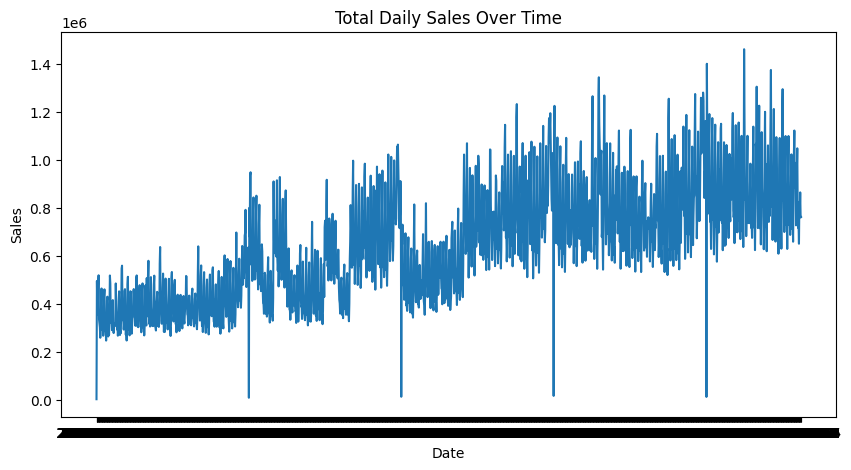

In [4]:
daily_sales = df.groupby('date')['sales'].sum().reset_index()

plt.figure(figsize=(10, 5))
plt.plot(daily_sales['date'], daily_sales['sales'])
plt.title('Total Daily Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

This line chart shows how total sales have changed over time.  
We can already start to see seasonal patterns and peaks.

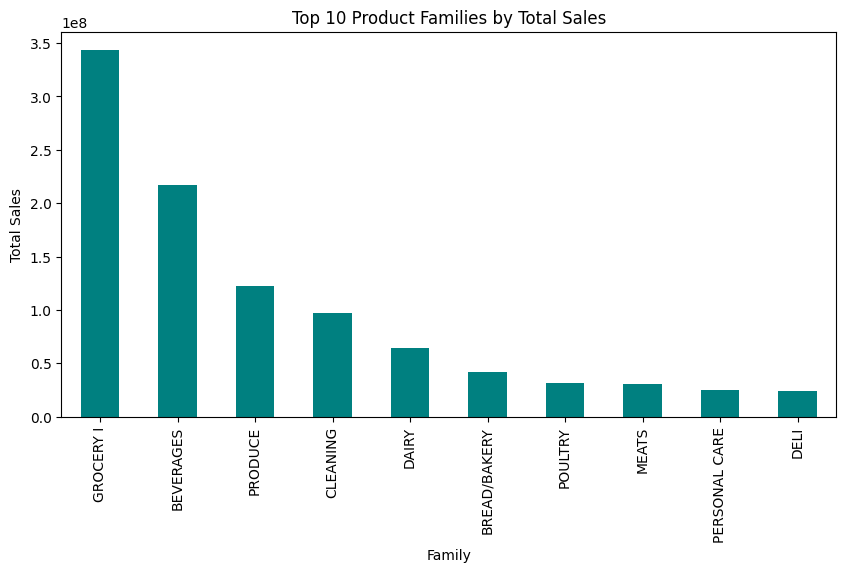

In [5]:
top_families = df.groupby('family')['sales'].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(10,5))
top_families.plot(kind='bar', color='teal')
plt.title('Top 10 Product Families by Total Sales')
plt.ylabel('Total Sales')
plt.xlabel('Family')
plt.show()

The bar chart highlights the most profitable product families,  
giving insight into which categories drive the most revenue.

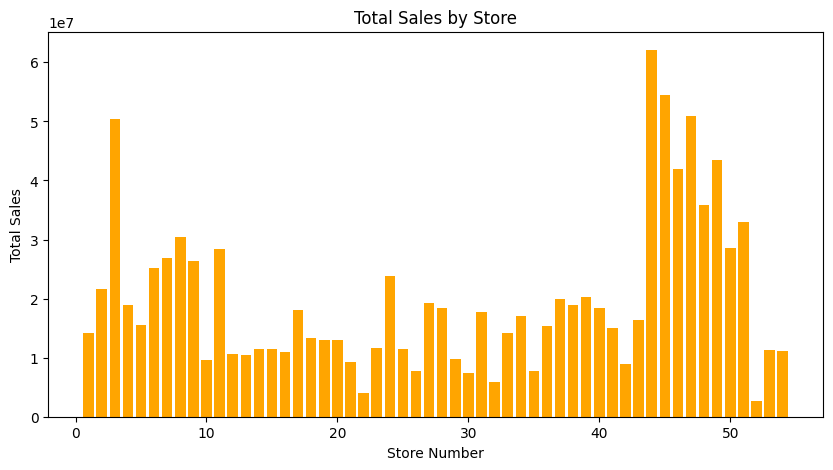

In [6]:
store_sales = df.groupby('store_nbr')['sales'].sum().reset_index()

plt.figure(figsize=(10,5))
plt.bar(store_sales['store_nbr'], store_sales['sales'], color='orange')
plt.title('Total Sales by Store')
plt.xlabel('Store Number')
plt.ylabel('Total Sales')
plt.show()

### 3.3 Summary

From the visualisations, we can see clear differences in sales patterns  
across time, product categories, and stores.  
This understanding will guide feature engineering for the modelling stage.

## Step 4 – Feature Engineering

In this step we add new time-based and rolling features to make the data more useful for analysis and future forecasting.
We'll include short and long-term averages, lag values, and time parts such as year, month, and day of week.

In [11]:
# Sort data and create group object
df = df.sort_values(['store_nbr', 'family', 'date'])
g = df.groupby(['store_nbr', 'family'], group_keys=False)

# Create lag features and moving averages
df['lag_1']  = g['sales'].shift(1)
df['lag_7']  = g['sales'].shift(7)
df['ma_7']   = g['sales'].transform(lambda s: s.rolling(7).mean())
df['ma_30']  = g['sales'].transform(lambda s: s.rolling(30).mean())

# Extract time parts
df['year']   = df['date'].dt.year
df['month']  = df['date'].dt.month
df['dow']    = df['date'].dt.day_name()

df[['date','store_nbr','family','sales','lag_1','lag_7','ma_7','ma_30']].head(10)

,date,store_nbr,family,sales,lag_1,lag_7,ma_7,ma_30
0,2013-01-01,1,AUTOMOTIVE,0.0,NaN,NaN,NaN,NaN
1,2013-01-02,1,AUTOMOTIVE,2.0,0.0,NaN,NaN,NaN
2,2013-01-03,1,AUTOMOTIVE,3.0,2.0,NaN,NaN,NaN
3,2013-01-04,1,AUTOMOTIVE,3.0,3.0,NaN,NaN,NaN
4,2013-01-05,1,AUTOMOTIVE,5.0,3.0,NaN,NaN,NaN
5,2013-01-06,1,AUTOMOTIVE,2.0,5.0,NaN,NaN,NaN
6,2013-01-07,1,AUTOMOTIVE,0.0,2.0,NaN,2.142857,NaN
7,2013-01-08,1,AUTOMOTIVE,2.0,0.0,0.0,2.428571,NaN
8,2013-01-09,1,AUTOMOTIVE,2.0,2.0,2.0,2.428571,NaN
9,2013-01-10,1,AUTOMOTIVE,2.0,2.0,3.0,2.285714,NaN


The new columns show short and long-term patterns in sales for each store and product family.
Lag features help capture the previous day and previous week sales, while moving averages smooth out fluctuations.

The new columns show short and long-term patterns in sales for each store and product family.
Lag features help capture the previous day and previous week sales, while moving averages smooth out fluctuations.

In [14]:
df.to_csv('../data/processed/train_features.csv', index=False)